# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        portfolio.print_holdings(row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(row, weights, field='close', directions=directions)

    # Record daily balance.
    portfolio.record_daily_balance(row)

2004-12-01 TLT_SHRT:  0 TLT:  0 GLD:  0 SPY:  0 cash: 10,000.00 total: 10,000.00
2005-01-03 TLT_SHRT: 20 TLT: 61 GLD: 22 SPY: 60 cash:    90.17 total: 10,076.99
2005-02-01 TLT_SHRT: 20 TLT: 60 GLD: 23 SPY: 59 cash:   181.33 total: 10,061.95
2005-03-01 TLT_SHRT: 19 TLT: 58 GLD: 23 SPY: 60 cash:   246.46 total: 10,158.15
2005-04-01 TLT_SHRT: 19 TLT: 59 GLD: 23 SPY: 59 cash:   280.55 total: 10,004.60
2005-05-02 TLT_SHRT: 19 TLT: 59 GLD: 23 SPY: 60 cash:   197.98 total: 10,038.08
2005-06-01 TLT_SHRT: 19 TLT: 57 GLD: 23 SPY: 61 cash:   221.31 total: 10,271.29
2005-07-01 TLT_SHRT: 18 TLT: 56 GLD: 24 SPY: 60 cash:   361.42 total: 10,272.68
2005-08-01 TLT_SHRT: 18 TLT: 56 GLD: 24 SPY: 60 cash:   361.42 total: 10,404.31
2005-09-01 TLT_SHRT: 19 TLT: 58 GLD: 24 SPY: 59 cash:   288.76 total: 10,449.44
2005-10-03 TLT_SHRT: 18 TLT: 56 GLD: 23 SPY: 60 cash:   398.85 total: 10,447.50
2005-11-01 TLT_SHRT: 19 TLT: 59 GLD: 22 SPY: 60 cash:   233.20 total: 10,308.75
2005-12-01 TLT_SHRT: 19 TLT: 59 GLD: 22

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,48.45,20,entry,SHRT,TLT_SHRT
1,2004-12-01,1,45.38,22,entry,LONG,GLD
2,2004-12-01,2,48.45,61,entry,LONG,TLT
3,2004-12-01,3,83.12,60,entry,LONG,SPY
4,2005-01-03,4,49.92,1,exit,LONG,TLT
5,2005-01-03,5,84.26,1,exit,LONG,SPY
6,2005-01-03,6,43.02,1,entry,LONG,GLD
7,2005-02-01,7,51.51,2,exit,LONG,TLT
8,2005-02-01,8,51.51,1,exit,SHRT,TLT_SHRT
9,2005-02-01,9,83.29,1,entry,LONG,SPY


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
365,2017-05-01,105.73,2023-07-28,99.81,-5.92,-5.92,1,21511.84,LONG,TLT
366,2017-07-03,116.09,2022-10-03,158.43,42.34,42.34,1,21554.18,LONG,GLD
367,2017-09-01,223.59,2023-07-28,456.92,233.33,233.33,1,21787.52,LONG,SPY
368,2017-10-02,120.77,2023-01-03,171.06,50.29,50.29,1,21837.81,LONG,GLD
369,2017-10-02,109.67,2023-07-28,99.81,-9.86,-9.86,1,21827.95,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
460,2023-01-03,377.97,2023-07-28,456.92,78.95,78.95,1,26412.15,LONG,SPY
461,2023-02-01,106.80,2023-07-28,99.81,-6.99,-27.95,4,26384.20,LONG,TLT
462,2023-05-01,102.58,2023-07-28,99.81,-2.77,-11.08,4,26373.13,LONG,TLT
463,2023-07-03,102.08,2023-07-28,99.81,-2.27,-2.27,1,26370.86,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2023-07-24,39747.64,39747.64,39747.64,208,100.17,1.00,-
2023-07-25,39810.36,39810.36,39810.36,208,100.17,1.00,-
2023-07-26,39840.42,39840.42,39840.42,208,100.17,1.00,-
2023-07-27,39498.40,39498.40,39498.40,208,100.17,1.00,-
2023-07-28,36377.64,36377.64,36377.64,0,36377.64,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2004-11-18
end                                                     2023-07-28
beginning_balance                                            10000
ending_balance                                            36377.64
total_net_profit                                          26377.64
gross_profit                                              31585.72
gross_loss                                                -5208.08
profit_factor                                                 6.06
return_on_initial_capital                                   263.78
annual_return_rate                                            7.15
trading_period                           18 years 8 months 10 days
pct_time_in_market                                           99.83
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

,cumul_total,weight,pct_cumul_total,relative_performance
TLT_SHRT,-$847.69,0.10,-0.03,-0.32
TLT,"$2,529.96",0.30,0.10,0.32
GLD,"$2,647.47",0.10,0.10,1.00
SPY,"$22,047.91",0.50,0.84,1.67
TOTAL,"$26,377.64",1.00,1.00,1.00


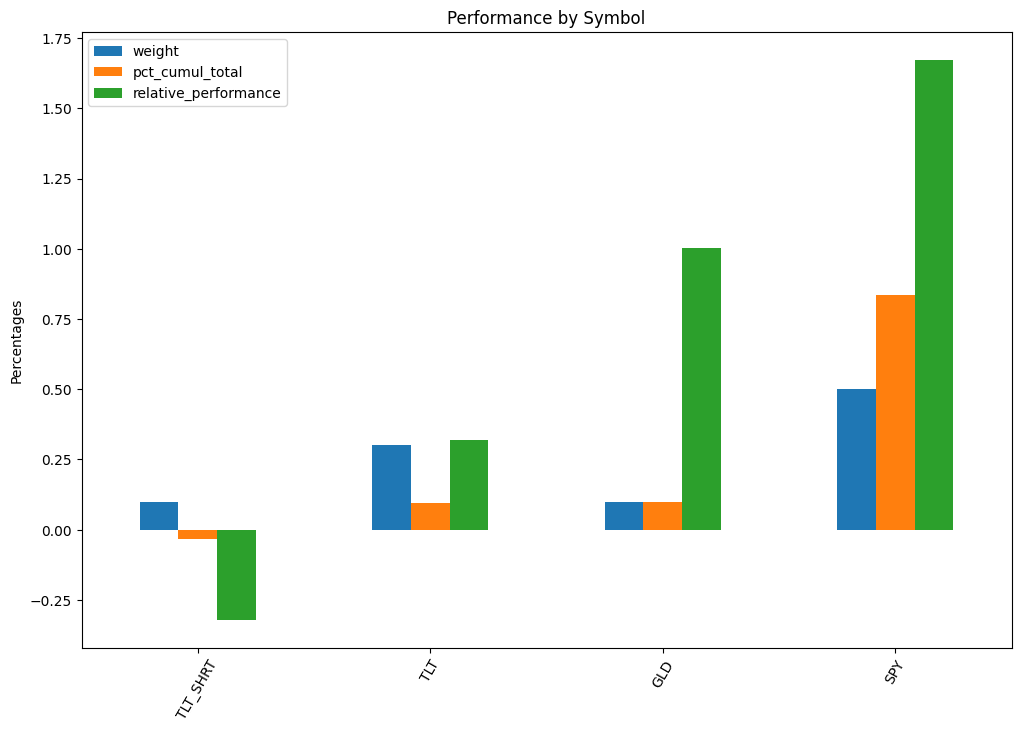

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

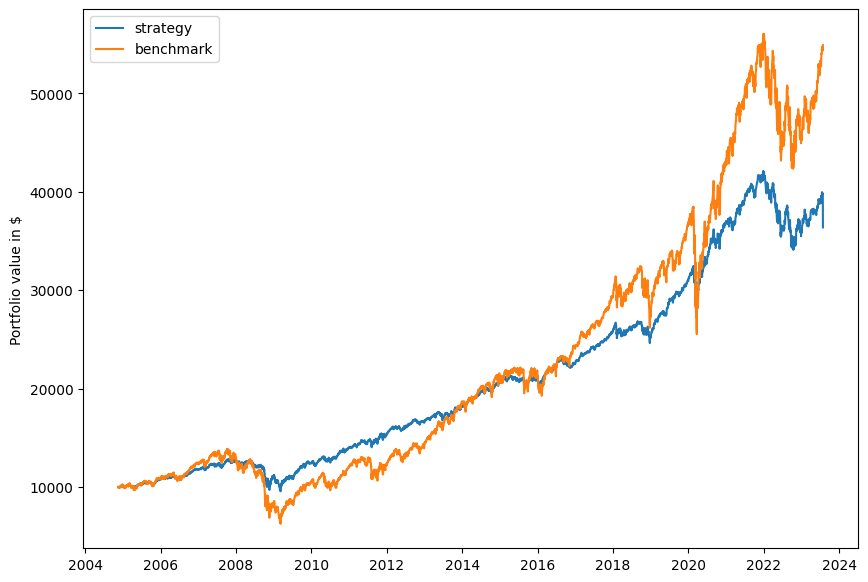

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$36,377.64","$54,897.41"
total_net_profit,"$26,377.64","$44,897.41"
gross_profit,"$31,585.72","$44,897.41"
gross_loss,"-$5,208.08",$0.00


,strategy,benchmark
annual_return_rate,7.15,9.54
max_closed_out_drawdown,-25.62,-54.92
annualized_return_over_max_drawdown,0.28,0.17
best_month,14.27,23.37
worst_month,-15.78,-30.93
sharpe_ratio,0.79,0.57
sortino_ratio,0.97,0.69
monthly_std,2.34,4.55
annual_std,8.49,16.42


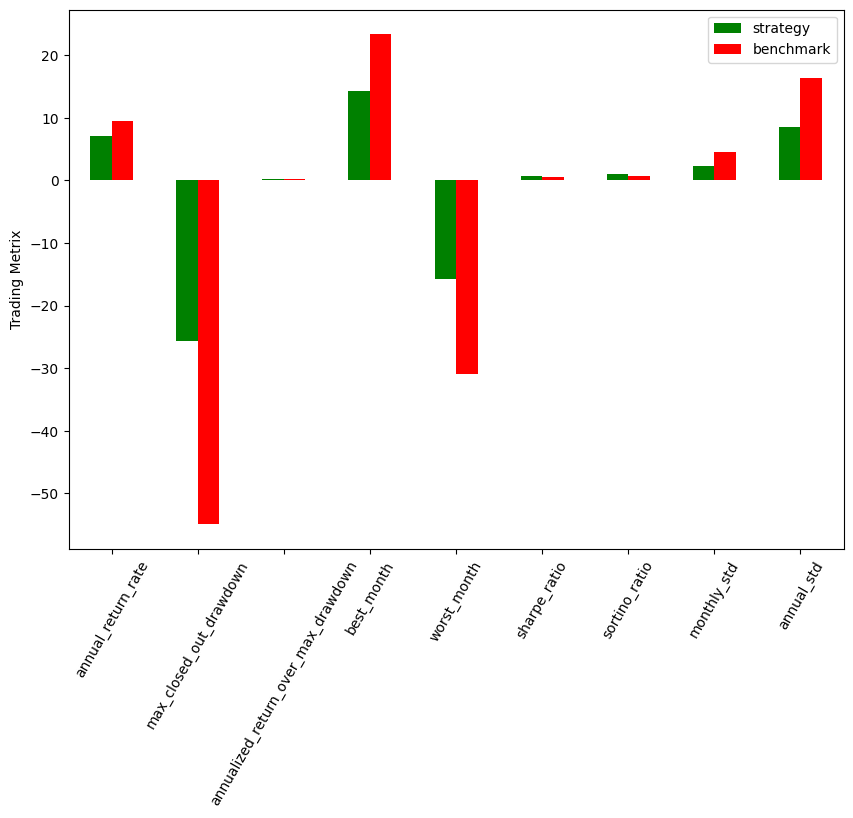

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df